In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import lightning.pytorch as pl
import torch
from matplotlib import pyplot as plt
import numpy as np
import pickle
from itertools import product, combinations_with_replacement
from skimage.morphology import disk, remove_small_objects
from skimage.measure import label, regionprops
from tqdm import tqdm
import pandas as pd 
from collections import defaultdict
import glob
from matplotlib import colors

sys.path.insert(1, sys.path[0] + '/..')
from src.data.datamodule import DataModule
from src.data.utils import simplify_labels
from src.model.setup import setup_model
from src.misc.utils import set_seed_and_precision
from src.misc.files import SetupArgs, read_image
from src.misc.post import calculate_metrics
from src.postprocess import _remove_low_probs, _remove_spine_fp, _remove_small_objects, _post_process
from src.postprocess import main as postprocess_main, parse_option as postprocess_parse_option
from src.data.utils import pad_tensor

from src.run import parse_option, main
args = parse_option(notebook=True)
args.data_dir = '../data_dev'
args.net = 'fracnet'
args.batch_size = 1
args.version = 'version_elias6'
args.num_workers = 8

Predict

In [2]:
args.train, args.predict = False, True
args.splits = ['train', 'val'] # note to sam: probably change this to val
# main(args)


postprocess_args = postprocess_parse_option(notebook=True)
postprocess_args.split = 'train'
postprocess_args.prediction_box_dir = os.path.join(args.log_dir, args.net, args.version, 'segmentations')
postprocess_args.original_image_dir = args.data_dir
postprocess_args.save_dir = os.path.join(args.log_dir, 'submissions', args.version, postprocess_args.split)


In [3]:
# img_ids = os.listdir(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))

In [4]:
def get_boxes(boxes_dir):
    return [np.load(filename)['arr_0'] for filename in glob.iglob(boxes_dir + '**/**/*.npz', recursive=True)]

In [5]:
y_true = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'labels'))
x_img     = get_boxes(os.path.join(postprocess_args.original_image_dir, 'boxes', postprocess_args.split, 'images'))
# y_pred = get_boxes(os.path.join(postprocess_args.prediction_box_dir, postprocess_args.split))

trained_unet = setup_model(args)


y_pred = []
for x_i in tqdm(x_img):
    xx = pad_tensor(torch.tensor(x_i), 0, 64).unsqueeze(0)
    yy = torch.tensor([-1])
    batch = (xx, yy)

    xx_pred, _ = trained_unet(batch)
    xx_pred = xx_pred.squeeze(0).detach().numpy()
    y_pred.append(xx_pred)


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


In [17]:
data = []
for i, j, k in zip(x_img, y_true, y_pred):
    s = np.array(i.shape)
    idxs = tuple([slice(0, s_i) for s_i in i.shape])
    p = k[idxs]

    # Setting a 'random' threshold
    # p = 1 * (p > 0.5)

    # Postprocessing
    p_post = p.copy()
    p_post = _post_process(pred = p, image = i, prob_thresh=gs_max.iloc[0]['prob_thresh'], bone_thresh=None, size_thresh=gs_max.iloc[0]['size_thresh'])
    p_post = simplify_labels(p_post)*1.

    j = simplify_labels(j)

    data.append( {'img': i, 'label': j, 'pred' : p, 'pred_post': p_post, } )

In [18]:
i = 0
for i in range(len(data)):
    p = data[i]['pred']
    p = 1 * (data[i]['pred'] > 0.5)
    print(i, data[i]['img'].shape,  (data[i]['label'] == p).mean())

0 (20, 34, 18) 0.9314542483660131
1 (20, 37, 21) 0.9281209781209782
2 (21, 36, 19) 0.9021164021164021
3 (21, 29, 19) 0.9230835709964567
4 (12, 15, 9) 0.9549382716049383
5 (26, 24, 20) 0.9217147435897436
6 (2, 11, 5) 0.6909090909090909
7 (15, 16, 10) 0.9379166666666666
8 (14, 16, 4) 0.9631696428571429
9 (21, 23, 14) 0.8955930198166223
10 (16, 29, 17) 0.8698022312373225
11 (20, 36, 12) 0.9430555555555555


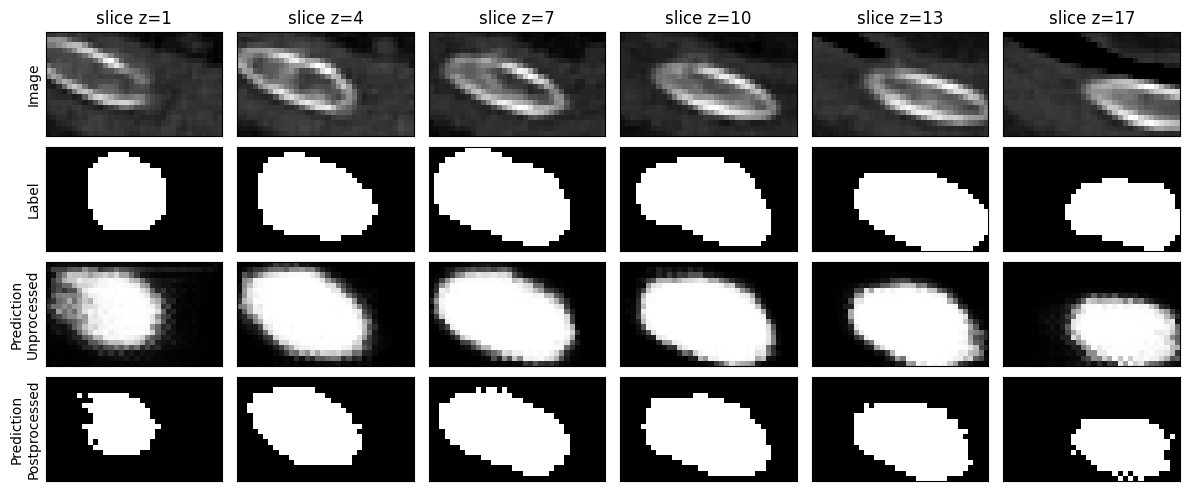

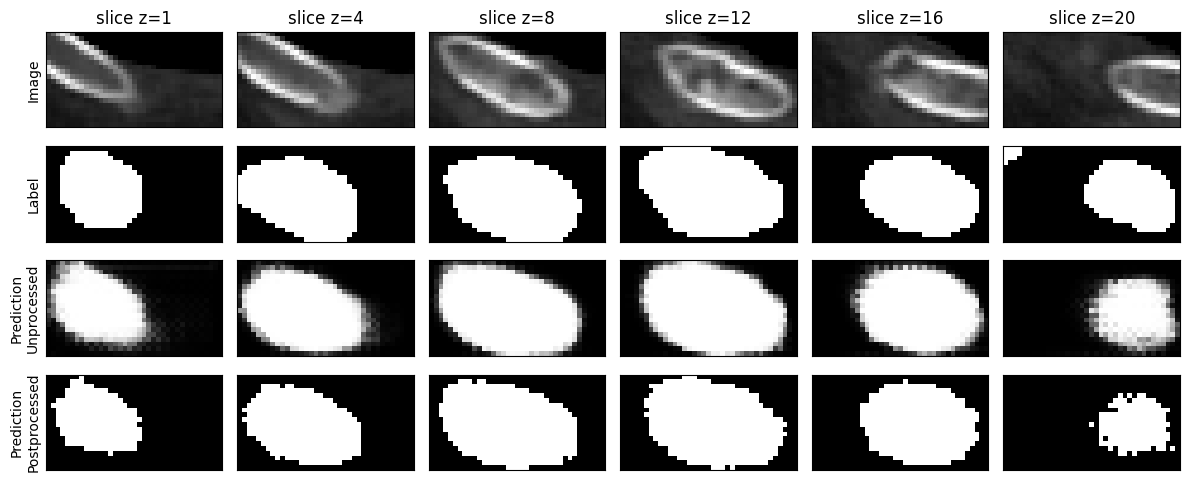

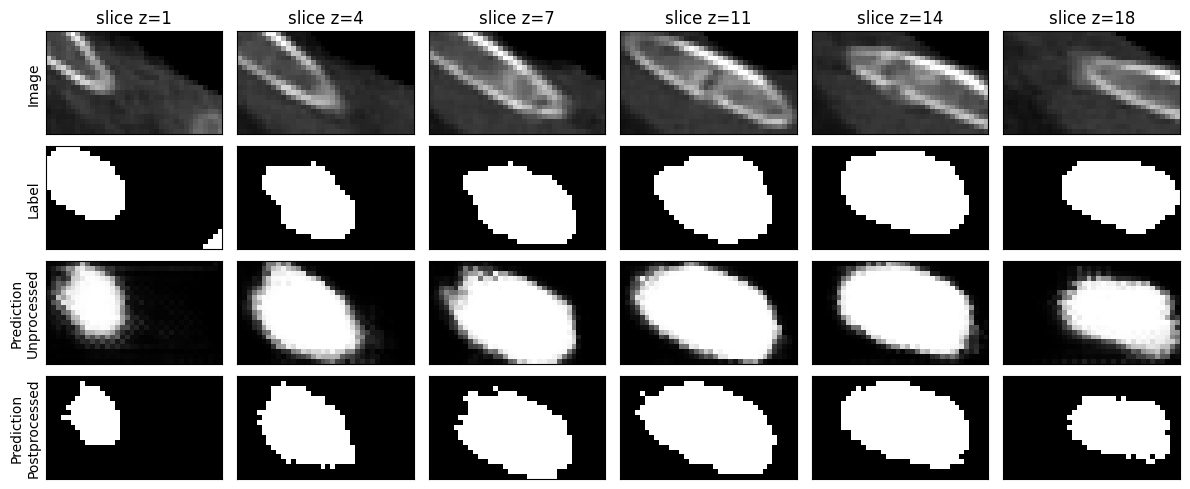

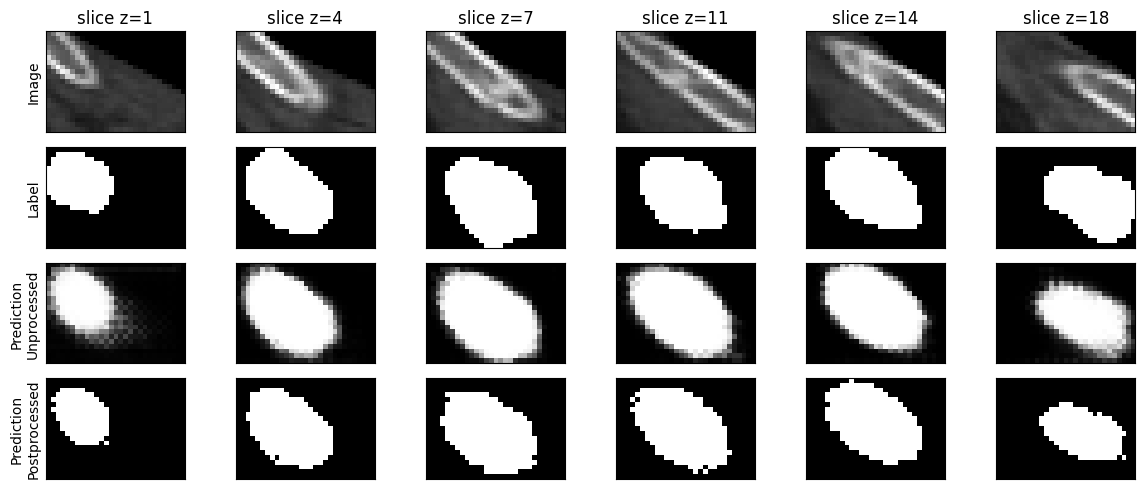

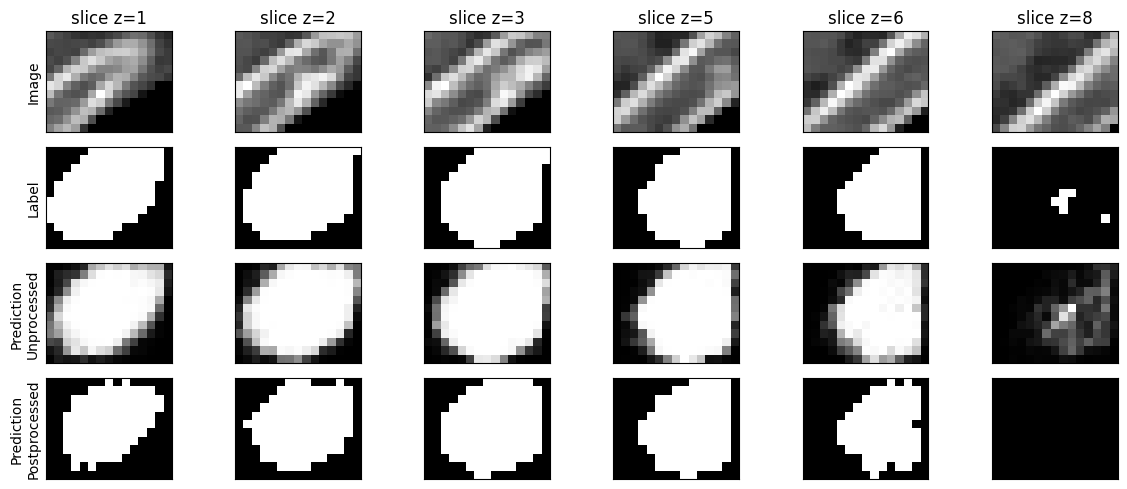

In [19]:
for d_i, d in enumerate(data):

    zs = d['img'].shape[-1]
    n = 6
    fig, axs = plt.subplots(len(d), n, figsize=(2.*n, 5), tight_layout=True)
    titles = ['Image', 'Label', 'Prediction\nUnprocessed', 'Prediction\nPostprocessed']
    zs_arr = np.linspace(0+1, zs-1, n, dtype=int)
    for i in range(len(titles)):
        axs[i, 0].set_ylabel(titles[i])
    for j, z in enumerate(zs_arr):
        axs_i = axs[:, j]
        for i, ax in enumerate(axs_i):
            ax.imshow(list(d.values())[i][:, :, z], cmap='gray')
            ax.set_xticks([])
            ax.set_yticks([])
        axs_i[0].set_title(f'slice z={z}')

    plt.show()

    if d_i > 3:
        break
    


In [9]:
len(data[0])

4

Gridsearch

In [10]:
l1, l2 = 101, 101
n1, n2 = 0, 0
ranges = {
    'prob_thresh' : np.linspace(0, 1, l1-1, endpoint = True),
    'bone_thresh' : np.array([200]),
    'size_thresh' : np.linspace(0, 3000, l2, endpoint = True),
    'prob_thresh_log' : np.logspace(-6, 0, l1-1, endpoint = True),
}

combis = []
combis_log = []
for i, x in enumerate(ranges['prob_thresh']):
        for k, z in enumerate(ranges['size_thresh']):
            if (i + k) < (l1 - n1 + l2 - n2):
            # if i <= k:
                # k = l2-k-1
                combis.append(np.array((ranges['prob_thresh'][i], ranges['bone_thresh'][0], ranges['size_thresh'][k])))
                combis_log.append(np.array((ranges['prob_thresh_log'][i], ranges['bone_thresh'][0], ranges['size_thresh'][k])))
combis = np.array(combis)
combis_log = np.array(combis_log)

gs = pd.DataFrame(columns = list(ranges.keys())[:3], data = combis)
gs_log = pd.DataFrame(columns = list(ranges.keys())[:3], data = combis_log)

for metric in ['accuracy', 'precision', 'recall']:
    gs[metric] = [[] for _ in range(len(gs))]
    gs_log[metric] = [[] for _ in range(len(gs))]

In [11]:
p_nonzero = np.array([])
device = 'cpu'

for d in data:
    x, y, p = d['img'], d['label'], d['pred']
    p_nonzero = np.append(p_nonzero, p[p != 0])

    y = torch.tensor(simplify_labels(y), device = device, dtype = torch.int)
    for i, combi in tqdm(gs.iterrows(), total=len(gs)):
        prob_thresh, bone_thresh, size_thresh = combi[:3]

        p_post = _post_process(pred = p, image = x, prob_thresh=prob_thresh, bone_thresh=bone_thresh, size_thresh=size_thresh)
        p_post = torch.tensor(simplify_labels(p_post), device = device, dtype = torch.int)
        
        metric = calculate_metrics(y, p_post)

        for k, v in metric.items():
            gs.loc[i, k].append(v)

    gs.to_csv('../store/grid_search.csv', index=False)

gs['accuracy_mean'] = gs['accuracy'].apply(lambda x: np.mean(x))
gs['precision_mean'] = gs['precision'].apply(lambda x: np.mean(x))
gs['recall_mean'] = gs['recall'].apply(lambda x: np.mean(x))
gs['accuracy_std'] = gs['accuracy'].apply(lambda x: np.std(x))
gs['precision_std'] = gs['precision'].apply(lambda x: np.std(x))
gs['recall_std'] = gs['recall'].apply(lambda x: np.std(x))

gs.to_csv('../store/grid_search.csv', index=False)


100%|██████████| 10100/10100 [00:02<00:00, 3765.71it/s]


In [12]:
# p_nonzero = np.array([])
# device = 'cpu'

# for d in data:
#     x, y, p = d['img'], d['label'], d['pred']
#     p_nonzero = np.append(p_nonzero, p[p != 0])

#     y = torch.tensor(simplify_labels(y), device = device, dtype = torch.int)
#     for i, combi in tqdm(gs_log.iterrows(), total=len(gs_log)):
#         prob_thresh, bone_thresh, size_thresh = combi[:3]

#         p_post = _post_process(pred = p, image = x, prob_thresh=prob_thresh, bone_thresh=bone_thresh, size_thresh=size_thresh)
#         p_post = torch.tensor(simplify_labels(p_post), device = device, dtype = torch.int)
        
#         metric = calculate_metrics(y, p_post)

#         for k, v in metric.items():
#             gs_log.loc[i, k].append(v)

#     gs_log.to_csv('../store/grid_search.csv', index=False)

# gs_log['accuracy_mean'] = gs_log['accuracy'].apply(lambda x: np.mean(x))
# gs_log['precision_mean'] = gs_log['precision'].apply(lambda x: np.mean(x))
# gs_log['recall_mean'] = gs_log['recall'].apply(lambda x: np.mean(x))
# gs_log['accuracy_std'] = gs_log['accuracy'].apply(lambda x: np.std(x))
# gs_log['precision_std'] = gs_log['precision'].apply(lambda x: np.std(x))
# gs_log['recall_std'] = gs_log['recall'].apply(lambda x: np.std(x))

# gs_log.to_csv('../store/grid_search.csv', index=False)


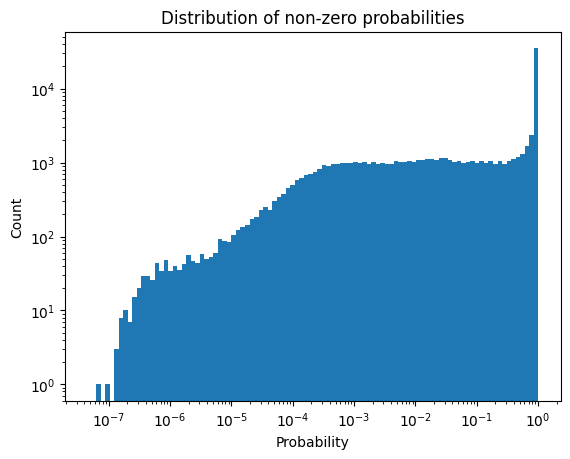

In [13]:
def plot_loghist(x, bins):
    hist, bins = np.histogram(x, bins=bins)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.hist(x, bins=logbins)
    plt.xscale('log')
plot_loghist(p_nonzero, 100)
plt.title('Distribution of non-zero probabilities')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

Analysis

In [14]:
# find indecies where recall is max
gs_max = gs[gs['precision_mean'] == gs['precision_mean'].max()]
gs_max

,prob_thresh,bone_thresh,size_thresh,accuracy,precision,recall,accuracy_mean,precision_mean,recall_mean,accuracy_std,precision_std,recall_std
8686,0.868687,200.0,0.0,"[0.9109477400779724, 0.9375160932540894, 0.924...","[0.9770828485488892, 0.9434099793434143, 0.902...","[0.804599940776825, 0.9176453948020935, 0.8885...",0.887049,0.951153,0.770715,0.112372,0.045357,0.25192


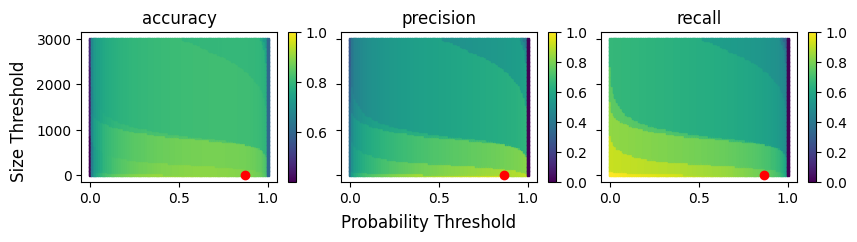

In [15]:
# for norm in [colors.Normalize(vmax=1), colors.LogNorm(vmax=1), None]:
fig, axs = plt.subplots(1, 3, figsize=np.array([11, 3])/1.3, sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', marker='s', s=2, vmax=1)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    # ax.set_xscale('log')
    ax.scatter(gs_max.iloc[0]['prob_thresh'], gs_max.iloc[0]['size_thresh'], c = 'red')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()

# fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

# for i, metric in enumerate(['accuracy', 'precision', 'recall']):
#     ax = axs[i]
#     im = ax.scatter(gs_log['prob_thresh'], gs_log['size_thresh'], c=gs_log[f'{metric}_mean'], cmap = 'viridis', marker='s', s=2)
#     fig.colorbar(im, ax=ax)
#     ax.set_title(metric)
#     ax.set_xscale('log')
# fig.supylabel('Size Threshold')
# fig.supxlabel('Probability Threshold')
# plt.show()
    


### Old analysis

In [16]:
assert False

AssertionError: 

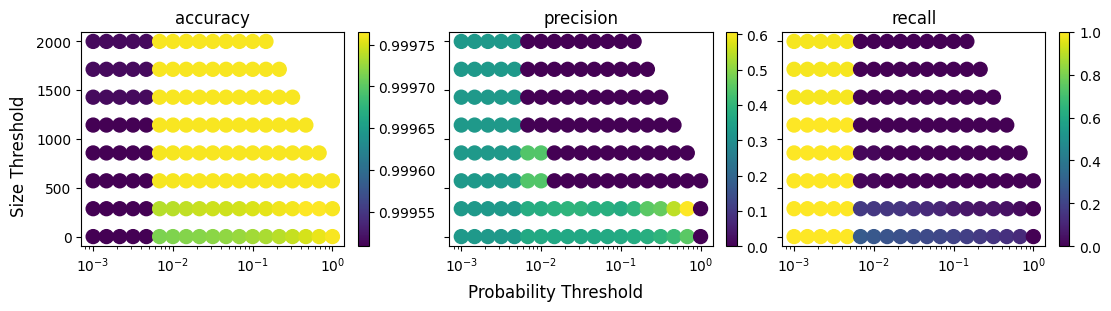

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    ax.set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()
    


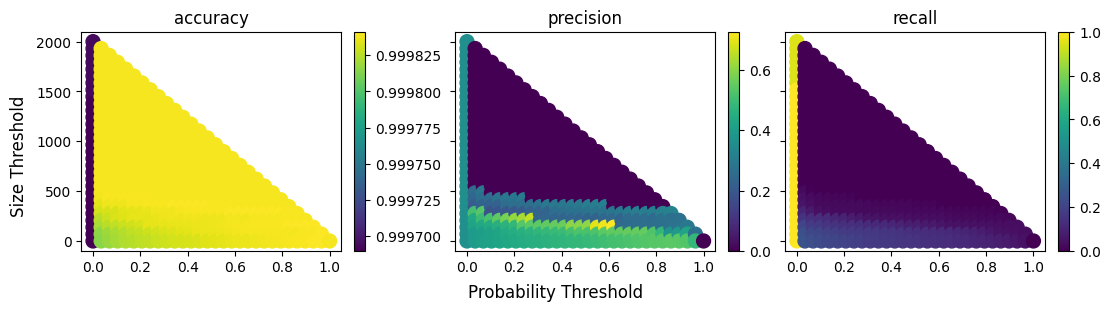

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    ax = axs[i]
    im = ax.scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    fig.colorbar(im, ax=ax)
    ax.set_title(metric)
    # ax.set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()

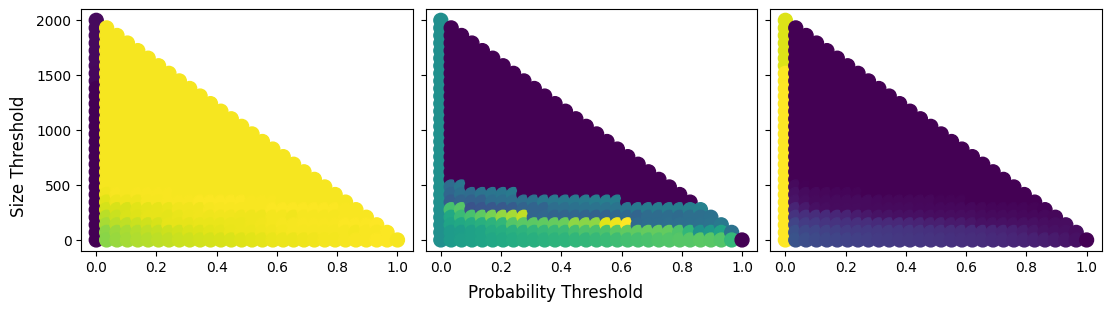

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharex=True, sharey=True, constrained_layout=True)

for i, metric in enumerate(['accuracy', 'precision', 'recall']):
    axs[i].scatter(gs['prob_thresh'], gs['size_thresh'], c=gs[f'{metric}_mean'], cmap = 'viridis', s = 100)
    # axs[i].set_xscale('log')
fig.supylabel('Size Threshold')
fig.supxlabel('Probability Threshold')
plt.show()
    


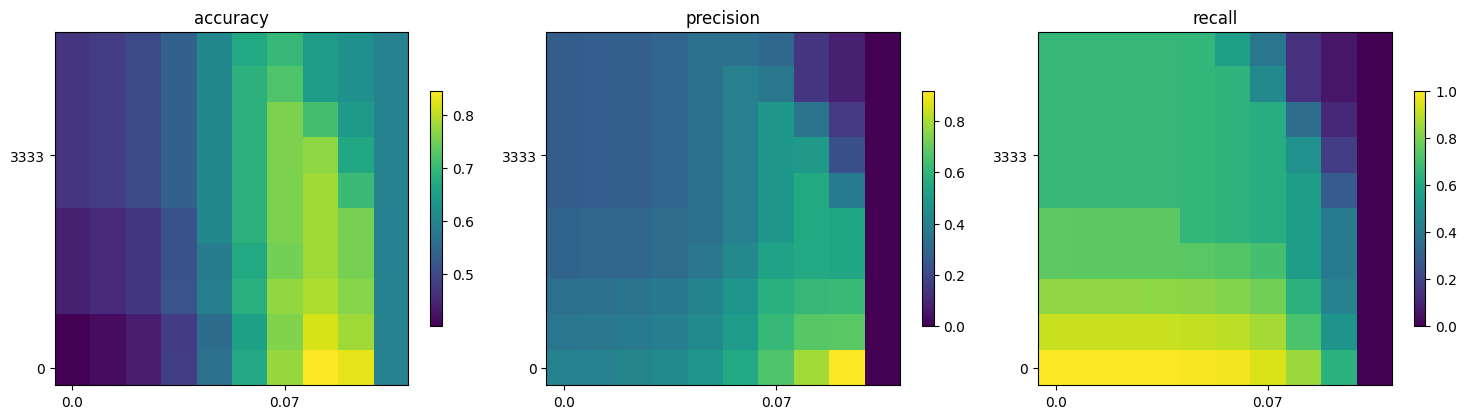

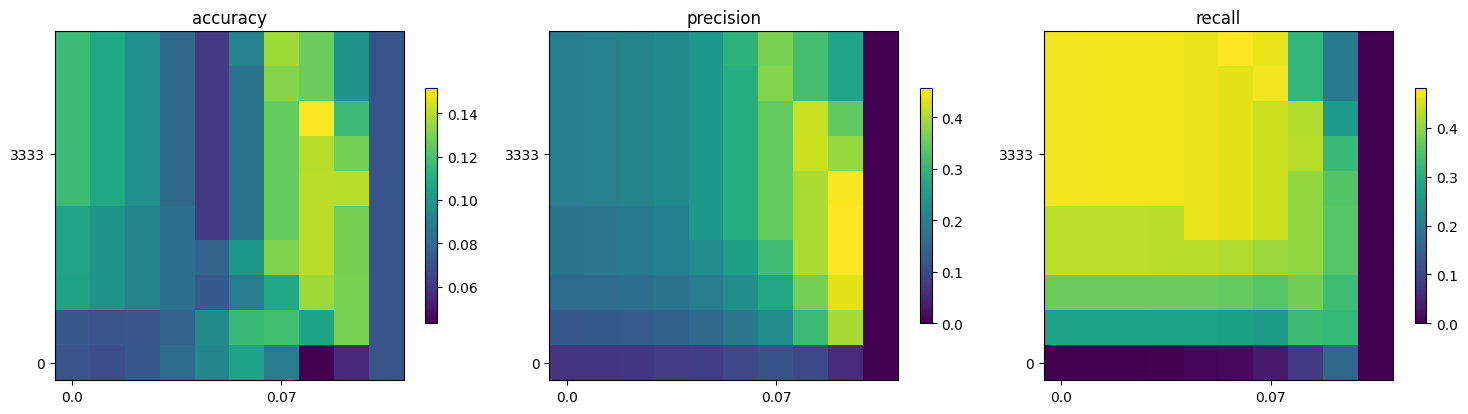

In [ ]:
metric_stats = ['mean', 'std']
for metric_stat in metric_stats:
    prob_thresh_values = gs['prob_thresh'].unique()
    size_thresh_values = gs['size_thresh'].unique()

    metrics = {k : np.zeros((len(prob_thresh_values), len(size_thresh_values))) for k in ['accuracy', 'precision', 'recall']}

    for i , prob_thresh_value in enumerate(prob_thresh_values):
        for j, size_thresh_value in enumerate(size_thresh_values):
            x = gs[(gs['prob_thresh'] == prob_thresh_value) & (gs['size_thresh'] == size_thresh_value)]
            if len(x) == 0:
                metrics['accuracy'][i, j] = np.nan
                metrics['precision'][i, j] = np.nan
                metrics['recall'][i, j] = np.nan
            else:
                metrics['accuracy'][i, j] = x.iloc[0][f'accuracy_{metric_stat}']
                metrics['precision'][i, j] = x.iloc[0][f'precision_{metric_stat}']
                metrics['recall'][i, j] = x.iloc[0][f'recall_{metric_stat}']

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

    for i, metric in enumerate(['accuracy', 'precision', 'recall']):
        ax = axs[i]
        cmap = ax.imshow(metrics[metric].T, cmap = 'viridis', origin='lower')
        fig.colorbar(cmap, ax=ax, shrink=0.5)

        ii = 6
        ax.set_yticks(np.arange(len(size_thresh_values))[::ii])
        ax.set_xticks(np.arange(len(prob_thresh_values))[::ii])
        # ax.set_yticks(np.linspace(0, len(size_thresh_values), ii, dtype=int, endpoint=True))
        # ax.set_xticks(np.linspace(0, len(prob_thresh_values), ii, dtype=int, endpoint=True))
        ax.set_yticklabels(np.round(size_thresh_values).astype(int)[::ii])
        ax.set_xticklabels(np.round(prob_thresh_values, 2)[::ii])
        # ax.set_yticklabels(np.linspace(0, size_thresh_values.max(), ii, dtype=int, endpoint=True))
        # ax.set_xticklabels(np.round(np.logs(0, prob_thresh_values.max(), ii, endpoint=True), 2))
        ax.set_title(metric)
    # fig.supylabel('Size Threshold')
    # fig.supxlabel('Probability Threshold')
    plt.show()

In [ ]:
metric_stats = ['mean', 'std']
for metric_stat in metric_stats:
    prob_thresh_values = gs['prob_thresh'].unique()
    size_thresh_values = gs['size_thresh'].unique()

    metrics = {k : np.zeros((len(prob_thresh_values), len(size_thresh_values))) for k in ['accuracy', 'precision', 'recall']}

    for i , prob_thresh_value in enumerate(prob_thresh_values):
        for j, size_thresh_value in enumerate(size_thresh_values):
            x = gs[(gs['prob_thresh'] == prob_thresh_value) & (gs['size_thresh'] == size_thresh_value)]
            if len(x) == 0:
                metrics['accuracy'][i, j] = np.nan
                metrics['precision'][i, j] = np.nan
                metrics['recall'][i, j] = np.nan
            else:
                metrics['accuracy'][i, j] = x.iloc[0][f'accuracy_{metric_stat}']
                metrics['precision'][i, j] = x.iloc[0][f'precision_{metric_stat}']
                metrics['recall'][i, j] = x.iloc[0][f'recall_{metric_stat}']

    fig, axs = plt.subplots(1, 3, figsize=(5, 5), tight_layout=True,)

    for i, metric in enumerate(['accuracy', 'precision', 'recall']):
        ax = axs[i]
        cmap = ax.imshow(metrics[metric].T, cmap = 'viridis', origin='lower')
        fig.colorbar(cmap, ax=ax, shrink=0.5)

        ii = 2
        ax.set_xscale('log')
        ax.set_box_aspect(1)


        # ax.set_yticks(np.arange(len(size_thresh_values))[::ii])
        # ax.set_xticks(np.arange(len(prob_thresh_values))[::ii])
        # ax.set_yticklabels(np.round(size_thresh_values).astype(int)[::ii])
        # ax.set_xticklabels(np.round(prob_thresh_values, 3)[::ii])


        # ax.set_yticks(np.arange(len(size_thresh_values))[::ii])
        # ax.set_xticks(np.arange(len(prob_thresh_values))[::ii])
        # ax.set_yticklabels(np.round(size_thresh_values).astype(int)[::ii])
        # ax.set_xticklabels(np.round(prob_thresh_values, 2)[::ii])
        # ax.set_yticks(np.linspace(0, len(size_thresh_values), ii, dtype=int, endpoint=True))
        # ax.set_xticks(np.linspace(0, len(prob_thresh_values), ii, dtype=int, endpoint=True))
        # ax.set_yticklabels(np.linspace(0, size_thresh_values.max(), ii, dtype=int, endpoint=False))
        # ax.set_xticklabels(np.round(np.linspace(0, prob_thresh_values.max(), ii, endpoint=False), 2))
        ax.set_title(metric)
    fig.supylabel('Size Threshold')
    fig.supxlabel('Probability Threshold')
    plt.show()

### Continue analysis

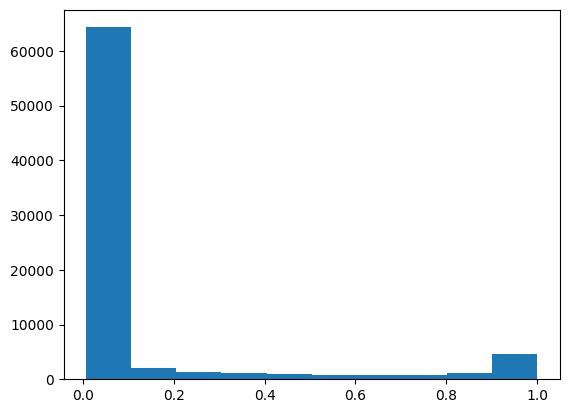

In [ ]:
plt.hist(y_pred_nonzero)
plt.show()